In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
from qiskit.circuit.random import random_circuit

from variational_algorithms import VQE, energy_evaluation, classical_solver
from costfunc_barren_plateaus import global2local

from state_efficient_ansatz import ansatz_constructor #SAE

In [2]:
num_qubits = 6
reps  = 2

num_qubits = 6
num_shots  = 2**13
optimizer = SPSA

In [3]:
# Exact
simulator_exact = AerSimulator(method = 'statevector')

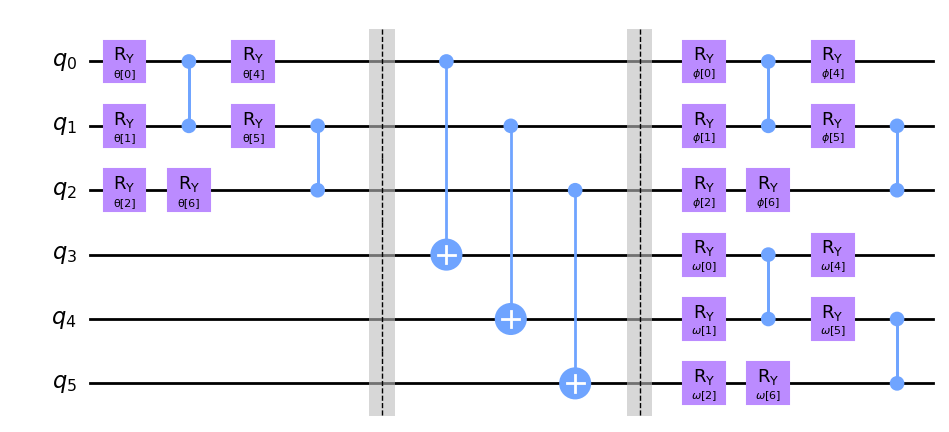

In [4]:
ansatz = ansatz_constructor( num_qubits )
t_ansatz = transpile(ansatz)

params = np.random.rand(t_ansatz.num_parameters) * np.pi
ansatz.decompose().draw( 'mpl' )